# December 2017: Advent of Code Solutions

Peter Norvig

I'm doing the [Advent of Code](https://adventofcode.com) puzzles, just like [last year](https://github.com/norvig/pytudes/blob/master/ipynb/Advent%20of%20Code.ipynb). This time, my terms of engagement are a bit different:

* I won't write a summary of each day's puzzle description. Follow the links in the section headers (e.g. **[Day 1](https://adventofcode.com/2017/day/1)**) to understand what each puzzle is asking. 
* What you see is mostly the algorithm I first came up with first, although sometimes I go back and refactor if I think the original is unclear.
* I do clean up the code a bit even after I solve the puzzle: adding docstrings, changing variable names, changing input boxes to `assert` statements.
* I will describe my errors that slowed me down.
* Some days I start on time and try to code very quickly (although I know that people at the top of the leader board will be much faster than me); other days I end up starting late and don't worry about going quickly.





# Day 0: Imports and Utility Functions

I might need these:

In [1]:
# Python 3.x Utility Functions

%matplotlib inline
import matplotlib.pyplot as plt

import re
import numpy as np
import math
import random

from collections import Counter, defaultdict, namedtuple, deque, abc, OrderedDict
from functools   import lru_cache
from statistics  import mean, median, mode, stdev, variance
from itertools   import (permutations, combinations, chain, cycle, product, islice, 
                         takewhile, zip_longest, count as count_from)
from heapq       import heappop, heappush

identity = lambda x: x
letters  = 'abcdefghijklmnopqrstuvwxyz'

cache = lru_cache(None)

cat = ''.join

Ø   = frozenset() # Empty set
inf = float('inf')
BIG = 10 ** 999

################ Functions for Input, Parsing

def Input(day, year=2017):
    "Open this day's input file."
    return open('data/advent{}/input{}.txt'.format(year, day))
    
def array(lines):
    "Parse an iterable of str lines into a 2-D array. If `lines` is a str, splitlines."
    if isinstance(lines, str): lines = lines.splitlines()
    return mapt(vector, lines)

def vector(line):
    "Parse a str into a tuple of atoms (numbers or str tokens)."
    return mapt(atom, line.replace(',', ' ').split())

def integers(text): 
    "Return a tuple of all integers in a string."
    return mapt(int, re.findall(r'\b[-+]?\d+\b', text))

def atom(token):
    "Parse a str token into a number, or leave it as a str."
    try:
        return int(token)
    except ValueError:
        try:
            return float(token)
        except ValueError:
            return token

################ Functions on Iterables

def first(iterable, default=None): return next(iter(iterable), default)

def first_true(iterable, pred=None, default=None):
    """Returns the first true value in the iterable.
    If no true value is found, returns *default*
    If *pred* is not None, returns the first item
    for which pred(item) is true."""
    # first_true([a,b,c], default=x) --> a or b or c or x
    # first_true([a,b], fn, x) --> a if fn(a) else b if fn(b) else x
    return next(filter(pred, iterable), default)

def nth(iterable, n, default=None):
    "Returns the nth item of iterable, or a default value"
    return next(islice(iterable, n, None), default)

def upto(iterable, maxval):
    "From a monotonically increasing iterable, generate all the values <= maxval."
    # Why <= maxval rather than < maxval? In part because that's how Ruby's upto does it.
    return takewhile(lambda x: x <= maxval, iterable)

def groupby(iterable, key=identity):
    "Return a dict of {key(item): [items...]} grouping all items in iterable by keys."
    groups = defaultdict(list)
    for item in iterable:
        groups[key(item)].append(item)
    return groups

def grouper(iterable, n, fillvalue=None):
    """Collect data into fixed-length chunks:
    grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"""
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

def overlapping(iterable, n):
    """Generate all (overlapping) n-element subsequences of iterable.
    overlapping('ABCDEFG', 3) --> ABC BCD CDE DEF EFG"""
    if isinstance(iterable, abc.Sequence):
        yield from (iterable[i:i+n] for i in range(len(iterable) + 1 - n))
    else:
        result = deque(maxlen=n)
        for x in iterable:
            result.append(x)
            if len(result) == n:
                yield tuple(result)
                
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    return overlapping(iterable, 2)

def sequence(iterable, type=tuple):
    "Coerce iterable to sequence: leave alone if already a sequence, else make it `type`."
    return iterable if isinstance(iterable, abc.Sequence) else type(iterable)

def join(iterable, sep=''):
    "Join the items in iterable, converting each to a string first."
    return sep.join(map(str, iterable))
                
def powerset(iterable):
    "Yield all subsets of items."
    items = list(iterable)
    for r in range(len(items)+1):
        for c in combinations(items, r):
            yield c
            
def quantify(iterable, pred=bool):
    "Count how many times the predicate is true."
    return sum(map(pred, iterable))

def shuffled(iterable):
    "Create a new list out of iterable, and shuffle it."
    new = list(iterable)
    random.shuffle(new)
    return new
    
flatten = chain.from_iterable
            
class Set(frozenset):
    "A frozenset, but with a prettier printer."
    def __repr__(self): return '{' + join(sorted(self), ', ') + '}'
    
def canon(items, typ=None):
    "Canonicalize these order-independent items into a hashable canonical form."
    typ = typ or (cat if isinstance(items, str) else tuple)
    return typ(sorted(items))

def mapt(fn, *args): 
    "Do a map, and make the results into a tuple."
    return tuple(map(fn, *args))
            
################ Math Functions
            
def transpose(matrix): return tuple(zip(*matrix))

def isqrt(n):
    "Integer square root (rounds down)."
    return int(n ** 0.5)

def ints(start, end):
    "The integers from start to end, inclusive: range(start, end+1)"
    return range(start, end + 1)

def floats(start, end, step=1.0):
    "Yields from start to end (inclusive), by increments of step."
    m = (1.0 if step >= 0 else -1.0)
    while start * m <= end * m:
        yield start
        start += step
        
def multiply(numbers):
    "Multiply all the numbers together."
    result = 1
    for n in numbers:
        result *= n
    return result

import operator as op

operations = {'>': op.gt, '>=': op.ge, '==': op.eq,
              '<': op.lt, '<=': op.le, '!=': op.ne,
              '+': op.add, '-': op.sub, '*': op.mul, 
              '/': op.truediv, '**': op.pow}

################ 2-D points implemented using (x, y) tuples

def X(point): x, y = point; return x
def Y(point): x, y = point; return y

origin = (0, 0)
UP, DOWN, LEFT, RIGHT = (0, 1), (0, -1), (-1, 0), (1, 0)

def neighbors4(point): 
    "The four neighboring squares."
    x, y = point
    return (          (x, y-1),
            (x-1, y),           (x+1, y), 
                      (x, y+1))

def neighbors8(point): 
    "The eight neighboring squares."
    x, y = point 
    return ((x-1, y-1), (x, y-1), (x+1, y-1),
            (x-1, y),             (x+1, y),
            (x-1, y+1), (x, y+1), (x+1, y+1))

def cityblock_distance(p, q=origin): 
    "Manhatten distance between two points."
    return abs(X(p) - X(q)) + abs(Y(p) - Y(q))

def distance(p, q=origin): 
    "Hypotenuse distance between two points."
    return math.hypot(X(p) - X(q), Y(p) - Y(q))

################ Debugging 

def trace1(f):
    "Print a trace of the input and output of a function on one line."
    def traced_f(*args):
        result = f(*args)
        print('{}({}) = {}'.format(f.__name__, ', '.join(map(str, args)), result))
        return result
    return traced_f

def grep(pattern, iterable):
    "Print lines from iterable that match pattern."
    for line in iterable:
        if re.search(pattern, line):
            print(line)

################ A* and Breadth-First Search (tracking states, not actions)

def always(value): return (lambda *args: value)

def Astar(start, moves_func, h_func, cost_func=always(1)):
    "Find a shortest sequence of states from start to a goal state (where h_func(s) == 0)."
    frontier  = [(h_func(start), start)] # A priority queue, ordered by path length, f = g + h
    previous  = {start: None}  # start state has no previous state; other states will
    path_cost = {start: 0}     # The cost of the best path to a state.
    Path      = lambda s: ([] if (s is None) else Path(previous[s]) + [s])
    while frontier:
        (f, s) = heappop(frontier)
        if h_func(s) == 0:
            return Path(s)
        for s2 in moves_func(s):
            g = path_cost[s] + cost_func(s, s2)
            if s2 not in path_cost or g < path_cost[s2]:
                heappush(frontier, (g + h_func(s2), s2))
                path_cost[s2] = g
                previous[s2] = s

def bfs(start, moves_func, goals):
    "Breadth-first search"
    goal_func = (goals if callable(goals) else lambda s: s in goals)
    return Astar(start, moves_func, lambda s: (0 if goal_func(s) else 1))

In [2]:
def tests():
    # Functions for Input, Parsing
    assert array('''1 2 3
                    4 5 6''') == ((1, 2, 3), 
                                  (4, 5, 6))
    assert vector('testing 1 2 3.') == ('testing', 1, 2, 3.0)
    
    # Functions on Iterables
    assert first('abc') == first(['a', 'b', 'c']) == 'a'
    assert first_true([0, None, False, {}, 42, 43]) == 42
    assert nth('abc', 1) == nth(iter('abc'), 1) == 'b'
    assert cat(upto('abcdef', 'd')) == 'abcd'
    assert cat(['do', 'g']) == 'dog'
    assert groupby([-3, -2, -1, 1, 2], abs) == {1: [-1, 1], 2: [-2, 2], 3: [-3]}
    assert list(grouper(range(8), 3)) == [(0, 1, 2), (3, 4, 5), (6, 7, None)]
    assert list(overlapping((0, 1, 2, 3, 4), 3)) == [(0, 1, 2), (1, 2, 3), (2, 3, 4)]
    assert list(overlapping('abcdefg', 4)) == ['abcd', 'bcde', 'cdef', 'defg']  
    assert list(pairwise((0, 1, 2, 3, 4))) == [(0, 1), (1, 2), (2, 3), (3, 4)]
    assert sequence('seq') == 'seq'
    assert sequence((i**2 for i in range(5))) == (0, 1, 4, 9, 16)
    assert join(range(5)) == '01234'
    assert join(range(5), ', ') == '0, 1, 2, 3, 4'
    assert multiply([1, 2, 3, 4]) == 24
    assert transpose(((1, 2, 3), (4, 5, 6))) == ((1, 4), (2, 5), (3, 6))
    assert isqrt(9) == 3 == isqrt(10)
    assert ints(1, 100) == range(1, 101)
    assert identity('anything') == 'anything'
    assert set(powerset({1, 2, 3})) == {
        (), (1,), (1, 2), (1, 2, 3), (1, 3), (2,), (2, 3), (3,)}
    assert quantify(['testing', 1, 2, 3, int, len], callable) == 2 # int and len are callable
    assert quantify([0, False, None, '', [], (), {}, 42]) == 1  # Only 42 is truish
    assert set(shuffled('abc')) == set('abc')
    assert canon('abecedarian') == 'aaabcdeeinr'
    assert canon([9, 1, 4]) == canon({1, 4, 9}) == (1, 4, 9)
    assert mapt(math.sqrt, [1, 9, 4]) == (1, 3, 2)
    
    # Math
    assert transpose([(1, 2, 3), (4, 5, 6)]) == ((1, 4), (2, 5), (3, 6))
    assert isqrt(10) == isqrt(9) == 3
    assert ints(1, 5) == range(1, 6)
    assert list(floats(1, 5)) == [1., 2., 3., 4., 5.]
    assert multiply(ints(1, 10)) == math.factorial(10) == 3628800
    
    # 2-D points
    P = (3, 4)
    assert X(P) == 3 and Y(P) == 4
    assert cityblock_distance(P) == cityblock_distance(P, origin) == 7
    assert distance(P) == distance(P, origin) == 5
    
    # Search
    assert Astar((4, 4), neighbors8, distance) == [(4, 4), (3, 3), (2, 2), (1, 1), (0, 0)]
    assert bfs((4, 4), neighbors8, {origin}) == [(4, 4), (3, 3), (2, 2), (1, 1), (0, 0)]
    forty2 = always(42)
    assert forty2() == forty2('?') == forty2(4, 2) == 42

    return 'pass'

tests()

'pass'

# [Day 1](https://adventofcode.com/2017/day/1): Inverse Captcha

This was easier than I remember last year's puzzles being:


In [183]:
digits = mapt(int, '3294199471327195994824832197564859876682638188889768298894243832665654681412886862234525991553276578641265589959178414218389329361496673991614673626344552179413995562266818138372393213966143124914469397692587251112663217862879233226763533911128893354536353213847122251463857894159819828724827969576432191847787772732881266875469721189331882228146576832921314638221317393256471998598117289632684663355273845983933845721713497811766995367795857965222183668765517454263354111134841334631345111596131682726196574763165187889337599583345634413436165539744188866156771585647718555182529936669683581662398618765391487164715724849894563314426959348119286955144439452731762666568741612153254469131724137699832984728937865956711925592628456617133695259554548719328229938621332325125972547181236812263887375866231118312954369432937359357266467383318326239572877314765121844831126178173988799765218913178825966268816476559792947359956859989228917136267178571776316345292573489873792149646548747995389669692188457724414468727192819919448275922166321158141365237545222633688372891451842434458527698774342111482498999383831492577615154591278719656798277377363284379468757998373193231795767644654155432692988651312845433511879457921638934877557575241394363721667237778962455961493559848522582413748218971212486373232795878362964873855994697149692824917183375545192119453587398199912564474614219929345185468661129966379693813498542474732198176496694746111576925715493967296487258237854152382365579876894391815759815373319159213475555251488754279888245492373595471189191353244684697662848376529881512529221627313527441221459672786923145165989611223372241149929436247374818467481641931872972582295425936998535194423916544367799522276914445231582272368388831834437562752119325286474352863554693373718848649568451797751926315617575295381964426843625282819524747119726872193569785611959896776143539915299968276374712996485367853494734376257511273443736433464496287219615697341973131715166768916149828396454638596713572963686159214116763')
N = len(digits)
N

2014

In [4]:
sum(digits[i] 
    for i in range(N) 
    if digits[i] == digits[i - 1])

1158

**Part Two**:

In [5]:
sum(digits[i] 
    for i in range(N) 
    if digits[i] == digits[i - N // 2])

1132

# [Day 2](https://adventofcode.com/2017/day/2): Corruption Checksum


In [6]:
rows2 = array('''790	99	345	1080	32	143	1085	984	553	98	123	97	197	886	125	947
302	463	59	58	55	87	508	54	472	63	469	419	424	331	337	72
899	962	77	1127	62	530	78	880	129	1014	93	148	239	288	357	424
2417	2755	254	3886	5336	3655	5798	3273	5016	178	270	6511	223	5391	1342	2377
68	3002	3307	166	275	1989	1611	364	157	144	3771	1267	3188	3149	156	3454
1088	1261	21	1063	1173	278	1164	207	237	1230	1185	431	232	660	195	1246
49	1100	136	1491	647	1486	112	1278	53	1564	1147	1068	809	1638	138	117
158	3216	1972	2646	3181	785	2937	365	611	1977	1199	2972	201	2432	186	160
244	86	61	38	58	71	243	52	245	264	209	265	308	80	126	129
1317	792	74	111	1721	252	1082	1881	1349	94	891	1458	331	1691	89	1724
3798	202	3140	3468	1486	2073	3872	3190	3481	3760	2876	182	2772	226	3753	188
2272	6876	6759	218	272	4095	4712	6244	4889	2037	234	223	6858	3499	2358	439
792	230	886	824	762	895	99	799	94	110	747	635	91	406	89	157
2074	237	1668	1961	170	2292	2079	1371	1909	221	2039	1022	193	2195	1395	2123
8447	203	1806	6777	278	2850	1232	6369	398	235	212	992	7520	7304	7852	520
3928	107	3406	123	2111	2749	223	125	134	146	3875	1357	508	1534	4002	4417''')

In [7]:
sum(abs(max(row) - min(row)) for row in rows2)

46402

**Part Two**:

In [8]:
def evendiv(row): 
    return first(a // b for a in row for b in row if a > b and a // b == a / b)

sum(map(evendiv, rows2))

265

This day was also very easy. It was nice that my pre-defined `array` function did the whole job of parsing the input. In Part One, I was slowed down by a typo: I had `"="` instead of `"-"` in `"max(row) - min(row)"`. I was confused by Python's misleading error message, which said `"SyntaxError: keyword can't be an expression"`. Later on, Alex Martelli explained to me that the message meant that in `abs(max(row)=...)` it thought that `max(row)` was a keyword argument to `abs`, as in `abs(x=-1)`.

In Part Two, note that to check that `a/b` is an exact integer, I used `a // b == a / b`, which I think is more clear  than the marginally-faster expression one would typically use here, `a % b == 0`, which requires you to think about two things: division and the modulus operator (is it `a % b` or `b % a`?).

# [Day 3](https://adventofcode.com/2017/day/3): Spiral Memory

For today the data is just one number:

In [9]:
M = 277678

This puzzle takes some thinking, not just fast typing. I decided to break the problem into three parts:
- Generate a spiral (by writing a new function called `spiral`).
- Find the Nth square on the spiral (with my function `nth`).
- Find the distance from that square to the center (with my function `cityblock_distance`).

I suspect many people will do all three of these in one function. That's probably the best way to get the answer really quickly, but I'd rather be clear than quick (and I'm anticipating that `spiral` will come in handy in Part Two), so I'll factor out each part, obeying the *single responsibility principle*. 

Now I need to make `spiral()` generate the coordinates of squares on an infinite spiral, in order, going out from the center square, `(0, 0)`. After the center square, the spiral goes 1 square right, then 1 square up, then 2 square left, then 2 square down, thus completing one revolution; then it does subsequent revolutions. In general if the previous revolution ended with *s* squares down, then the next revolution consists of *s*+1 squares right, *s*+1 squares up, *s*+2 squares left and *s*+2 down.  A small test confirms that this matches the example diagram in the puzzle description (although I had a bug on my first try because I only incremented `s` once per revolution, not twice):

In [10]:
def spiral():
    "Yield successive (x, y) coordinates of squares on a spiral."
    x = y = s = 0   # (x, y) is the position; s is the side length.
    yield (x, y)
    while True:
        for (dx, dy) in (RIGHT, UP, LEFT, DOWN):
            if dy: s += 1 # Increment side length before RIGHT and LEFT
            for _ in range(s):
                x += dx; y += dy
                yield (x, y)

list(islice(spiral(), 10))

[(0, 0),
 (0, 1),
 (-1, 1),
 (-1, 0),
 (-1, -1),
 (0, -1),
 (1, -1),
 (1, 0),
 (1, 1),
 (1, 2)]

Now we can find the `N`th square. As this is Python, indexes start at 0, whereas the puzzle description starts counting at 1, so I have to subtract 1. Then I can find the distance to the origin:

In [11]:
nth(spiral(), M - 1)

(263, 212)

In [12]:
cityblock_distance(_)

475

For **Part Two** I can re-use my `spiral` generator, yay! Here's a function to sum the neighboring squares (I can use my `neighbors8` function, yay!):

In [13]:
def spiralsums():
    "Yield the values of a spiral where each square has the sum of the 8 neighbors."
    value = defaultdict(int)
    for p in spiral():
        value[p] = sum(value[q] for q in neighbors8(p)) or 1
        yield value[p]

In [14]:
list(islice(spiralsums(), 12))

[1, 1, 2, 4, 5, 10, 11, 23, 25, 26, 54, 57]

Looks good, so let's get the answer:

In [15]:
first(x for x in spiralsums() if x > M)

279138

# [Day 4](https://adventofcode.com/2017/day/4): High-Entropy Passphrases

This is the first time I will have to store an input file and read it with the function `Input`. It should be straightforward, though:

In [16]:
def is_valid(line): return is_unique(line.split())

def is_unique(items): return len(items) == len(set(items))

quantify(Input(4), is_valid)

337

**Part Two:**

In [17]:
def is_valid2(line): return is_unique(mapt(canon, line.split()))

quantify(Input(4), is_valid2)

231

That was easy, and I started on time, but the leaders were still three times faster than me!

# [Day 5](https://adventofcode.com/2017/day/5): A Maze of Twisty Trampolines, All Alike

Let's first make sure we can read the data/program okay:

In [18]:
program = mapt(int, Input(5))

program[:10]

(0, 2, 0, 0, -2, -2, -1, -4, -5, -6)

Now I'll make a little interpreter, `run`, which takes a program, loads it into memory,
 and executes the instruction, maintaining a program counter, `pc`, and doing the incrementing/branching as described in the puzzle,
until the program counter is out of range:

In [19]:
def run(program):
    memory = list(program)
    pc = steps = 0
    while pc in range(len(memory)):
        steps += 1
        oldpc = pc
        pc += memory[pc]
        memory[oldpc] += 1
    return steps
        
run(program)

364539

**Part Two:**

Part Two seems tricky, so I'll include an optional argument, `verbose`, and check if the printout it produces matches the example in the puzzle description:

In [20]:
def run2(program, verbose=False):
    memory = list(program)
    pc = steps = 0
    while pc in range(len(memory)):
        steps += 1
        oldpc = pc
        pc += memory[pc]
        memory[oldpc] += (-1 if memory[oldpc] >= 3 else 1)
        if verbose: print(steps, pc, memory)
    return steps
        
run2([0, 3, 0, 1, -3], True)

1 0 [1, 3, 0, 1, -3]
2 1 [2, 3, 0, 1, -3]
3 4 [2, 2, 0, 1, -3]
4 1 [2, 2, 0, 1, -2]
5 3 [2, 3, 0, 1, -2]
6 4 [2, 3, 0, 2, -2]
7 2 [2, 3, 0, 2, -1]
8 2 [2, 3, 1, 2, -1]
9 3 [2, 3, 2, 2, -1]
10 5 [2, 3, 2, 3, -1]


10

That looks right, so I can solve the puzzle:

In [21]:
run2(program)

27477714

Thanks to [Clement Sreeves](https://github.com/ClementSreeves) for the suggestion of making a distinction between the `program` and the `memory`. In my first version, `run` would mutate the argument, which was OK for a short exercise, but not best practice for a reliable API.

# [Day 6](https://adventofcode.com/2017/day/6): Memory Reallocation 

I had to read the puzzle description carefully, but then it is pretty clear what to do. I'll keep a set of previously seen configurations, which will all be tuples. But in the function `spread`, I want to mutate the configuration of banks, so I will convert to a list at the start, then convert back to a tuple at the end.

In [22]:
banks = vector('4	10	4	1	8	4	9	14	5	1	14	15	0	15	3	5')

def realloc(banks):
    "How many cycles until we reach a configuration we've seen before?"
    seen = {banks}
    for cycles in count_from(1):
        banks = spread(banks)
        if banks in seen:
            return cycles
        seen.add(banks)
        
def spread(banks):
    "Find the area with the most blocks, and spread them evenly to following areas."
    banks  = list(banks)
    maxi   = max(range(len(banks)), key=lambda i: banks[i])
    blocks = banks[maxi]
    banks[maxi] = 0
    for i in range(maxi + 1, maxi + 1 + blocks):
        banks[i % len(banks)] += 1
    return tuple(banks)

In [23]:
spread((0, 2, 7, 0))

(2, 4, 1, 2)

In [24]:
realloc((0, 2, 7, 0))

5

These tests look good; let's solve the problem:

In [25]:
realloc(banks)

12841

**Part Two:** Here I will just replace the `set` of `seen` banks with a `dict` of `{bank: cycle_number}`; everything else is the same, and the final result is the current cycle number minus the cycle number of the previously-seen tuple of banks.

In [26]:
def realloc2(banks):
    "When we hit a cycle, what is the length of the cycle?"
    seen = {banks: 0}
    for cycles in count_from(1):
        banks = spread(banks)
        if banks in seen:
            return cycles - seen[banks]
        seen[banks] = cycles

realloc2((0, 2, 7, 0))

4

In [29]:
realloc2(banks)

8038

# [Day 7](https://adventofcode.com/2017/day/7): Recursive Circus

First I'll read the data into two dicts as follows: the input line:

     tcmdaji (40) -> wjbdxln, amtqhf
     
creates:

     weight['tcmdaji'] = 40
     above['tcmdaji'] = ['wjbdxln', 'amtqhf']

In [30]:
def towers(lines):
    "Return (weight, above) dicts."
    weight = {}
    above = {}
    for line in lines:
        name, w, *rest = re.findall(r'\w+', line)
        weight[name] = int(w)
        above[name] = set(rest)
    return weight, above

weight, above = towers(Input(7))

programs = set(above)

Now the root progam is the one that is not above anything:

In [31]:
programs - set(flatten(above.values()))

{'wiapj'}

**Part Two:**

A program is *wrong* if it is the bottom of a tower that is a different weight from all its sibling towers:

In [32]:
def wrong(p): return tower_weight(p) not in map(tower_weight, siblings(p))

Here we define `tower_weight`, `siblings`, and the `below` dict:

In [33]:
def tower_weight(p): 
    "Total weight for the tower whose root (bottom) is p."
    return weight[p] + sum(map(tower_weight, above[p]))

def siblings(p): 
    "The other programs at the same level as this one."
    if p not in below:
        return Ø # the root has no siblings
    else:
        return above[below[p]] - {p}

below = {a: b for b in programs for a in above[b]}

In [34]:
set(filter(wrong, programs))

{'eionkb', 'lsire', 'wiapj', 'ycpcv'}

So these four programs are wrong. Which one should we correct? The one that is wrong, and has no wrong program above it:

In [35]:
def wrongest(programs):
    return first(p for p in programs
                 if wrong(p) 
                 and not any(wrong(p2) for p2 in above[p]))

wrongest(programs)                              

'eionkb'

Now what should we correct it to? To the weight that makes it the same weight as the sibling towers:

In [38]:
def correct(p):
    "Return the weight that would make p's tower's weight the same as its sibling towers."
    delta = tower_weight(first(siblings(p))) - tower_weight(p) 
    return weight[p] + delta

correct(wrongest(programs))

1072

# [Day 8](https://adventofcode.com/2017/day/8): Memory Reallocation 

This one looks easy: a simple interpreter for straight-line code where each instruction has 7 tokens. It is nice that my `array` function parses the whole program.

In [39]:
program8 = array(Input(8))

def run8(program):
    "Run the program and return final value of registers."
    registers = defaultdict(int)
    for (r, inc, delta, _if, r2, cmp, amount) in program:
        if operations[cmp](registers[r2], amount):
            registers[r] += delta * (+1 if inc == 'inc' else -1)
    return registers

max(run8(program8).values())

6828

**Part Two:**

Here I modify the interpreter to keep track of the highest value of any register at any time.

In [40]:
def run82(program):
    registers = defaultdict(int)
    highest = 0
    for r, inc, delta, _if, r2, cmp, amount in program:
        if operations[cmp](registers[r2], amount):
            registers[r] += delta * (+1 if inc == 'inc' else -1)
            highest = max(highest, registers[r])
    return highest

run82(program8)

7234

# [Day 9](https://adventofcode.com/2017/day/9): Stream Processing

For this problem I could have a single finite-state machine that handles all five magic characters, `'{<!>}'`, but I think it is easier to first clean up the garbage, using regular expressions:

In [41]:
text1 = re.sub(r'!.', '', Input(9).read()) # Delete canceled characters
text2 = re.sub(r'<.*?>', '', text1)        # Delete garbage

text2[:70]

'{{{{{{{},},{{},}},{{{{}},{{{{{}}},{}},},{{{{},{,{{{}}}}},},{{{}},{{}}}'

Now I can deal with the nested braces (which can't be handled with regular expressions). The puzzle says "*Each group is assigned a score which is one more than the score of the group that immediately contains it,*" which is the same as saying that a group's score is its nesting level, a quantity that increases with each open-brace character, and decreases with each close-brace:

In [42]:
def total_score(text):
    "Total of group scores; each group scores one more than the group it is nested in."
    total = 0
    level = 0 # Level of nesting
    for c in text:
        if c == '{':
            level += 1
            total += level
        elif c == '}':
            level -= 1
    return total

total_score(text2)

9662

**Part Two:**

At first I thought that the amount of garbage is just the difference in lengths of `text2` and `text3`:

In [43]:
len(text1) - len(text2)

5989

But this turned out to be wrong; it counts the angle brackets themselves s being deleted, whereas the puzzle is actually asking how many character between the angle brackets are deleted. So that would be:

In [44]:
text3 = re.sub(r'<.*?>', '<>', text1)  # Delete garbage inside brackets, but not brackets

len(text1) - len(text3)

4903

# [Day 10](https://adventofcode.com/2017/day/10): Stream Processing

I have to do a bunch of reversals of substrings of `stream`. It looks complicated so I will include a `verbose` argument to `knothash` and confirm it works on the example puzzle. I break out the reversal into a separate function, `rev`. The way I handle reversal interacting with wraparound is that I first move all the items before the reversal position to the end of the list, then I do the reversal, then I move them back.

In [45]:
stream = (63,144,180,149,1,255,167,84,125,65,188,0,2,254,229,24)

def knothash(lengths, N=256, verbose=False):
    "Do a reversal for each of the numbers in `lengths`."
    nums = list(range(N))
    pos = skip = 0
    for L in lengths:
        nums = rev(nums, pos, L)
        if verbose: print(nums)
        pos = (pos + L + skip) % N
        skip += 1
    return nums[0] * nums[1]
        
def rev(nums, pos, L):
    "Reverse nums[pos:pos+L], handling wrap-around."
    # Move first pos elements to end, reverse first L, move pos elements back
    nums = nums[pos:] + nums[:pos]
    nums[:L] = reversed(nums[:L])
    nums = nums[-pos:] + nums[:-pos]
    return nums

In [46]:
# Reverse [0, 1, 2]:
assert rev(list(range(5)), 0, 3) == [2, 1, 0, 3, 4]

In [47]:
# Reverse [4, 0, 1], wrapping around:
assert rev(list(range(5)), 4, 3) == [0, 4, 2, 3, 1]

In [48]:
# Duplicate the example output
assert knothash((3, 4, 1, 5), N=5, verbose=True) == 12

[2, 1, 0, 3, 4]
[4, 3, 0, 1, 2]
[4, 3, 0, 1, 2]
[3, 4, 2, 1, 0]


That's correct, but the first time through I got it wrong because I forgot the `"% N"` on the update of `pos`.

In [49]:
knothash(stream)

4480

**Part Two**:

Now it gets *really* complicated: string processing, the suffix, hex string output, and dense hashing. But just take them one at a time:

In [50]:
stream2 = '63,144,180,149,1,255,167,84,125,65,188,0,2,254,229,24'

def knothash2(lengthstr, N=256, rounds=64, suffix=(17, 31, 73, 47, 23),
              verbose=False):
    "Do a reversal for each length; repeat `rounds` times."
    nums = list(range(N))
    lengths = mapt(ord, lengthstr) + suffix
    pos = skip = 0
    for round in range(rounds):
        for L in lengths:
            nums = rev(nums, pos, L)
            if verbose: print(nums)
            pos = (pos + L + skip) % N
            skip += 1
    return hexstr(dense_hash(nums))

def hexstr(nums): 
    "Convert a sequence of (0 to 255) ints into a hex str."
    return cat(map('{:02x}'.format, nums))
    
def dense_hash(nums, blocksize=16): 
    "XOR each block of nums, return the list of them."
    return [XOR(block) for block in grouper(nums, blocksize)]

def XOR(nums):
    "Exclusive-or all the numbers together."
    result = 0
    for n in nums:
        result ^= n
    return result
    
assert XOR([65, 27, 9, 1, 4, 3, 40, 50, 91, 7, 6, 0, 2, 5, 68, 22]) == 64
assert hexstr([255, 0, 17]) == 'ff0011'

assert knothash2('') == 'a2582a3a0e66e6e86e3812dcb672a272'

knothash2(stream2)

'c500ffe015c83b60fad2e4b7d59dabc4'

I had a bug: originally I used `'{:x}'` as the format instead of `'{:02x}'`; the later correctly formats `0` as `'00'`, not `'0'`.

# [Day 11](https://adventofcode.com/2017/day/11): Hex Ed

The first thing I did was search [`[hex coordinates]`](https://www.google.com/search?source=hp&ei=Ft4xWoOqKcy4jAOs76a4CQ&q=hex+coordinates), and the #1 result (as I expected) was Amit Patel's "[Hexagonal Grids](https://www.redblobgames.com/grids/hexagons/)" page. I chose his "odd-q vertical layout" to define the six directions as (dx, dy) deltas:

In [51]:
directions6 = dict(n=(0, -1), ne=(1, 0), se=(1, 1), s=(0, 1), sw=(-1, 0), nw=(-1, -1))

Now I can read the path, follow it, and see where it ends up. If the end point is `(x, y)`, then it will take `max(abs(x), abs(y))` steps to get back to the origin, because each step can increment or decrement either `x` or `y` or both.

In [52]:
path = vector(Input(11).read())

def follow(path):
    "Follow each step of the path; return final distance to origin."
    x, y = (0, 0)
    for (dx, dy) in map(directions6.get, path):
        x += dx; y += dy
    return max(abs(x), abs(y))

follow(path)

705

This one seemed so easy that I didn't bother testing it on the simple examples in the puzzle; all I did was confirm that the answer for my puzzle input was correct.

**Part Two:**

This looks pretty easy; repeat Part One, but keep track of the maximum number of steps we get from the origin at any point in the path:

In [53]:
def follow2(path):
    "Follow each step of the path; return max steps to origin."
    x = y = maxsteps = 0
    for (dx, dy) in map(directions6.get, path):
        x += dx; y += dy
        maxsteps = max(maxsteps, abs(x), abs(y))
    return maxsteps

follow2(path)

1469

Again, no tests, just the final answer.

# [Day 12](https://adventofcode.com/2017/day/12): Digital Plumber

First I'll parse the data, creating a dict of `{program: direct_group_of_programs}`:

In [54]:
def groups(lines):
    "Dict of {i: {directly_connected_to_i}"
    return {lhs: {lhs} | set(rhs)
            for (lhs, _, *rhs) in array(lines)}
    
assert groups(Input(12))[0] == {0, 659, 737}

That looks good. I recognize this as a [Union-Find](https://en.wikipedia.org/wiki/Disjoint-set_data_structure) problem, for which there are efficient algorithms. But for this small example, I don't need efficiency, I need clarity and simplicity. So I'll write `merge` to take a dict and merge together the sets that are connected:

In [55]:
def merge(G):
    "Merge all indirectly connected groups together."
    for i in G:
        for j in list(G[i]):
            if G[i] != G[j]:
                G[i].update(G[j])
                G[j] = G[i]
    return G

G = merge(groups(Input(12)))

In [56]:
len(G[0])

115

That's the answer for Part One.

**Part Two**

I did almost all the work; I just need to count the number of distinct groups. That's a set of sets, and regular `set`s are not hashable, so I use my `Set` class:

In [57]:
len({Set(G[i]) for i in G})

221

# [Day 13](https://adventofcode.com/2017/day/13): Packet Scanners

First thing: The puzzle says the data is *depth: range*, but `range` has a meaning in Python, so I'll use the term *width* instead.

Second thing: I misread the puzzle description and mistakenly thought the scanners were going in a circular route,
so that they'd be at the top at any time that is 0 mod *width*. That gave the wrong answer and I realized the scanners are actually going back-and-forth, so with a width of size *n*, it takes *n* - 1 steps to get to the bottom, and *n* - 1 steps to get back to the top, so the scanner will be 
at the top at times that are multiples of 2(*n* - 1). For example, with width 3, that would be times 0, 4, 8, ... 

In [58]:
def trip_severity(scanners): 
    "The sum of sevrities for each time the packet is caught."
    return sum((d * w if caught(d, w) else 0) 
               for (d, w) in scanners)

def caught(depth, width):
    "Does the scanner at this depth/width catch the packet?"
    return depth % (2 * (width - 1)) == 0

example = ((0, 3), (1, 2), (4, 4), (6, 4))
assert trip_severity(example) == 24

In [75]:
scanners = mapt(integers, Input(13))
scanners[:5]

((0, 3), (1, 2), (2, 4), (4, 6), (6, 4))

In [76]:
trip_severity(scanners)

1504

**Part Two**

A packet is safe if no scanner catches it. We now have the possibility of a delay, so I update `caught` to allow for an optional delay, and define `safe_delay`:  

In [60]:
def caught(depth, width, delay=0):
    "Does the scanner at this depth/width catch the packet with this delay?"
    return (depth + delay) % (2 * (width - 1)) == 0 

def safe_delay(scanners):
    "Find the first delay such that no scanner catches the packet."
    safe = lambda delay: not any(caught(d, w, delay) for (d, w) in scanners)
    return first(filter(safe, count_from(0)))

safe_delay(example)

10

In [61]:
safe_delay(scanners)

3823370

# [Day 14](https://adventofcode.com/2017/day/14): Disk Defragmentation

I found this puzzle description confusing: are they talking about what I call `knothash`, or is it `knothash2`? I decided for the latter, which turned out to be right:

In [62]:
key = 'ljoxqyyw'

In [63]:
def bits(key, i):
    "The bits in the hash of this key with this row number."
    hash = knothash2(key + '-' + str(i))
    return format(int(hash, base=16), '0128b')

sum(bits(key, i).count('1') for i in range(128))

8316

**Part Two**

So as not to worry about running off the edge of the grid, I'll surround the grid with `'0'` bits:

In [64]:
def Grid(key, N=128+2):
    "Make a grid, with a border around it."
    rows  = [['0'] + list(bits(key, i)) + ['0'] for i in range(128)]
    empty =  ['0'] * len(rows[0])
    return [empty] + rows + [empty]

To find a region, start at some `(x, y)` position and [flood fill](https://en.wikipedia.org/wiki/Flood_fill) to neighbors that have the same value (a `'1'` bit).

In [65]:
def flood(grid, x, y, val, R):
    "For all cells with value val connected to grid[x][y], give them region number R."
    if grid[y][x] == val:
        grid[y][x] = R
        for x2, y2 in neighbors4((x, y)):
            flood(grid, x2, y2, val, R)

In [66]:
def flood_all(grid, val='1'):
    "Label all regions with consecutive ints starting at 1."
    R = 0 # R is the region number
    for y in range(1, len(grid) - 1):
        for x in range(1, len(grid) - 1):
            if grid[y][x] == val:
                R += 1
                flood(grid, x, y, val, R)
    return R 

In [67]:
flood_all(Grid(key))

1074

# [Day 15](https://adventofcode.com/2017/day/15): Dueling Generators

There are lots of arbitrary integers below: my personalized inputs are `516` and `190`; the other numbers are shared by all puzzle-solvers. I decided to make infinite generators of numbers, using `gen`:

In [68]:
def gen(prev, factor, m=2147483647):
    "Generate an infinite sequence of numbers according to the rules."
    while True:
        prev = (prev * factor) % m
        yield prev
        
def judge(A, B, N=40*10**6, b=16): 
    "How many of the first N pairs from A and B agree in the last b bits?"
    m = 2 ** b
    return quantify(next(A) % m == next(B) % m
                    for _ in range(N))
        
A = lambda: gen(516, 16807)
B = lambda: gen(190, 48271)

judge(A(), B())

597

**Part Two**

A small change: only consider numbers that match the **criteria** of being divisible by 4 or 8, respectively;

In [69]:
def criteria(m, iterable): 
    "Elements of iterable that are divisible by m"
    return (n for n in iterable if n % m == 0)
        
judge(criteria(4, A()), criteria(8, B()), 5*10**6)

303

# [Day 16](https://adventofcode.com/2017/day/16): Permutation Promenade

Let's read the input and check that it looks reasonable:

In [79]:
dance = vector(Input(16).read())
dance[:10]

('x5/15',
 's15',
 'x1/3',
 'pn/f',
 'x11/2',
 's13',
 'x6/3',
 'pe/a',
 'x14/12',
 's15')

In [108]:
len(dance)

10000

I'll define `perform` to perform the dance:

In [171]:
dancers = 'abcdefghijklmnop'

def perform(dance, dancers=dancers):
    D = deque(dancers)
    def swap(i, j): D[i], D[j] = D[j], D[i]
    for move in dance:
        op, arg = move[0], move[1:]
        if   op == 's': D.rotate(int(arg))
        elif op == 'x': swap(*integers(arg))
        elif op == 'p': swap(D.index(arg[0]), D.index(arg[2]))
    return cat(D)
            
perform(dance)

'lbdiomkhgcjanefp'

That's the right answer.

**Part Two**

My first thought was to define a dance as a permutation: a list of numbers `[11, 1, 9, ...]` which says that the net effect of the dance is that the first dancer (`a`) ends up in position, the second (`b`) stays in position 1, and so on. Applying that permutation once is a lot faster than interpreting all 10,000 moves of the dance, and it is feasible to apply the permutation a billion times. I tried that (code not shown here), but that was a mistake: it took 15 minutes to run, and it got the wrong answer. The problem is that a dance is *not* just a permutation, because a dance can reference dancer *names*, not just positions.

It would take about 10,000 times 20 minutes to perform a billion repetitions of the dance, so that's out. But even though the dance is not a permutation, it might repeat after a short period. Let's check:

In [184]:
seen = {dancers: 0}
d = dancers
for i in range(1, 1000):
    d = perform(dance, d)
    if d in seen:
        print(d, 'is seen in iterations', (seen[d], i))
        break

abcdefghijklmnop is seen in iterations (0, 56)


So we get back to the start position after 56 repetitions of the dance. What happens after a billion repetitions?

In [187]:
1000000000 % 56

48

The end position after a billion repetitions is the same as after 48:

In [170]:
def whole(N, dance, dancers=dancers):
    "Repeat `perform(dance)` N times."
    for i in range(N):
        dancers = perform(dance, dancers)
    return dancers
    
whole(48, dance)

'ejkflpgnamhdcboi'

# Wrapping Up: Verification and Timing

Here is a little test harness to verify that I still get the right answers (even if I refactor some of the code):

In [158]:
%%time
def day(n, compute1, answer1, compute2, answer2):
    "Assert that we get the right answers for this day."
    assert compute1 == answer1
    assert compute2 == answer2

day(1,  sum(digits[i] for i in range(N) if digits[i] == digits[i - 1]), 1158,
        sum(digits[i] for i in range(N) if digits[i] == digits[i - N // 2]), 1132)
day(2,  sum(abs(max(row) - min(row)) for row in rows2), 46402, 
        sum(map(evendiv, rows2)), 265)
day(3,  cityblock_distance(nth(spiral(), M - 1)), 475, 
        first(x for x in spiralsums() if x > M), 279138)
day(4,  quantify(Input(4), is_valid), 337, quantify(Input(4), is_valid2), 231)
day(5,  run(program), 364539, run2(program), 27477714)
day(6,  realloc(banks), 12841, realloc2(banks), 8038)
day(7,  first(programs - set(flatten(above.values()))), 'wiapj', 
        correct(wrongest(programs)), 1072)
day(8,  max(run8(program8).values()), 6828, run82(program8), 7234)
day(9,  total_score(text2), 9662, len(text1) - len(text3), 4903)
day(10, knothash(stream), 4480, 
        knothash2(stream2), 'c500ffe015c83b60fad2e4b7d59dabc4')
day(11, follow(path), 705, follow2(path), 1469)
day(12, len(G[0]), 115, len({Set(G[i]) for i in G}), 221)
day(13, trip_severity(scanners), 1504, safe_delay(scanners), 3823370)
day(14, sum(bits(key, i).count('1') for i in range(128)), 8316, 
        flood_all(Grid(key)), 1074)
day(15, judge(A(), B()), 597, 
        judge(criteria(4, A()), criteria(8, B()), 5*10**6), 303)
day(16, perform(dance), 'lbdiomkhgcjanefp', 
        whole(48, dance), 'ejkflpgnamhdcboi')

CPU times: user 1min 8s, sys: 171 ms, total: 1min 8s
Wall time: 1min 8s


And here is a plot of the time taken to completely solve both parts of each puzzle each day, for me, the first person to finish, and the hundredth person. On days when I  started late, I estimate my time and mark it with parens below:

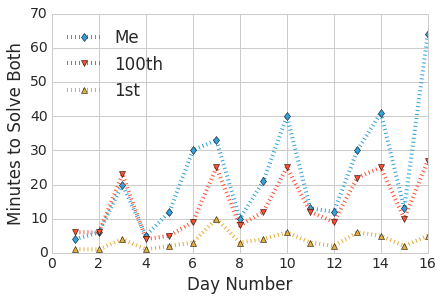

In [186]:
def plot_times(times):
    plt.style.use('seaborn-whitegrid')
    X = ints(1, len(times[0]) - 2)
    for (label, mark, *Y) in times:
        plt.plot(X, Y, mark, label=label)
    plt.xlabel('Day Number'); plt.ylabel('Minutes to Solve Both')
    plt.legend(loc='upper left')

x = None
plot_times([
    ('Me',    'd:', (4), 6,(20), 5, 12, 30, 33,(10), 21, 40, 13, 12,(30),(41), 13, 64),
    ('100th', 'v:',  6,  6, 23,  4,  5,  9, 25,  8,  12, 25, 12,  9, 22,  25,  10, 27),
    ('1st',   '^:',  1,  1,  4,  1,  2,  3, 10,  3,   4,  6,  3,  2,  6,   5,   2,  5)])